In [ ]:
!pip install pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 66.2 MB/s eta 0:00:00


In [ ]:
import json
import random
import logging
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from spacy.training import Example
import spacy
import fitz  #from  pymupdf


In [ ]:
def remove_overlapping_entities(entities):
    entities = sorted(entities, key=lambda x: (x[0], x[1]))
    cleaned_entities = []

    for start, end, label in entities:
        if not cleaned_entities:
            cleaned_entities.append((start, end, label))
        else:
            last_start, last_end, last_label = cleaned_entities[-1]
            if start < last_end:
                if end > last_end:
                    cleaned_entities[-1] = (last_start, end, last_label)
                elif end == last_end:
                    continue
            else:
                cleaned_entities.append((start, end, label))

    return cleaned_entities


In [ ]:
def validate_and_correct_entities(text, entities, nlp):
    doc = nlp.make_doc(text)
    corrected_entities = []
    for start, end, label in entities:
        span = doc.char_span(start, end, alignment_mode="contract")
        if span is None or span.text.strip() == "":
            continue
        corrected_entities.append((span.start_char, span.end_char, label))
    return corrected_entities

In [ ]:
def convert_dataturks_to_spacy(dataturks_JSON_FilePath, nlp):
    try:
        training_data = []
        lines = []
        with open(dataturks_JSON_FilePath, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        if not lines:
            #logging.error(f"The file {dataturks_JSON_FilePath} is empty.")
            return None

        for line in lines:
            try:
                data = json.loads(line)
            except json.JSONDecodeError as e:
                #logging.error(f"Error decoding JSON on line: {line}\nError: {e}")
                continue

            text = data['content']
            entities = []
            for annotation in data.get('annotation', []):
                point = annotation['points'][0]
                labels = annotation['label']
                if not isinstance(labels, list):
                    labels = [labels]

                for label in labels:
                    entities.append((point['start'], point['end'] + 1, label))

            entities = remove_overlapping_entities(entities)
            entities = validate_and_correct_entities(text, entities, nlp)
            training_data.append((text, {"entities": entities}))

        return training_data
    except Exception as e:
        #logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None


# **Model Training**

In [ ]:
def train_spacy():
    print("...........model training starts.................. ")

    nlp = spacy.blank('en')  # create blank Language class
    TRAIN_DATA = convert_dataturks_to_spacy(r"/content/drive/MyDrive/Colab Notebooks/EntityFrame/traindata.json", nlp)

    if TRAIN_DATA is None:
        print("No training data found. Exiting training.")
        return

    if 'ner' not in nlp.pipe_names:
        ner = nlp.add_pipe('ner', last=True)

    for _, annotations in TRAIN_DATA:
        for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(10):
            print("Starting iteration " + str(itn))
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                try:
                    nlp.update(
                        [example],
                        drop=0.2,
                        sgd=optimizer,
                        losses=losses)
                except Exception as e:
                    #logging.exception(f"Error updating model with text: {text}\nError: {e}")
                    print(losses)
    print("........... model training finished successfully.................. ")
    #Test model


    # Load PDF and extract text
    pdf_path = r"/content/drive/MyDrive/Colab Notebooks/EntityFrame/sample_input.pdf"
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()

    # Test the trained model on extracted text
    # doc_to_test = nlp(text)
    # d = {}
    # for ent in doc_to_test.ents:
    #     d[ent.label_] = []
    # for ent in doc_to_test.ents:
    #     d[ent.label_].append(ent.text)

    # for label, values in d.items():
    #     print(f"\nEntities for label '{label}':")
    #     for value in set(values):
    #         print(value.replace('\n', ''))

    # Additional evaluation metrics can be added here if needed
    # Save the trained model
    nlp.to_disk('/content/drive/MyDrive/Colab Notebooks/NTT Recog')


train_spacy()


...........Hey darling, model training starts.................. 
Starting iteration 0
{'ner': 1298.4841665029526}
{'ner': 1537.232303738594}
{'ner': 1537.232303738594}
{'ner': 2709.8161244392395}
{'ner': 2709.8161244392395}
{'ner': 2709.8161244392395}
{'ner': 5171.352490255295}
{'ner': 5171.352490255295}
{'ner': 6315.942863078823}
{'ner': 6579.815104528817}
{'ner': 6595.371668117433}
{'ner': 6735.276162057496}
{'ner': 6769.440356495513}
{'ner': 6906.311655731678}
{'ner': 6906.311655731678}
{'ner': 7139.805128729359}
{'ner': 8207.327627920104}
{'ner': 8666.387105025044}
{'ner': 8727.151966806068}
{'ner': 9830.205976098676}
{'ner': 9934.671527706018}
{'ner': 9997.09021644768}
{'ner': 10023.005470248325}
{'ner': 10691.189926771955}
{'ner': 10886.313010925183}
{'ner': 10984.448999713015}
{'ner': 10984.448999713015}
{'ner': 12121.741139537}
{'ner': 12755.103048464018}
{'ner': 13000.34470175743}
{'ner': 13039.825055136338}
{'ner': 13641.041716704654}
{'ner': 13706.199493325237}
Starting iter

# **pdf text Extraction**

In [ ]:
import spacy
import fitz

# Load the trained model
nlp = spacy.load('/content/drive/MyDrive/Colab Notebooks/NTT Recog')

# Load PDF and extract text
pdf_path = r"/content/drive/MyDrive/Colab Notebooks/EntityFrame/sample_input.pdf"
doc = fitz.open(pdf_path)
text = ""
for page in doc:
    text += page.get_text()
    print(text)

# Test the trained model on extracted text
doc_to_test = nlp(text)
d = {}
for ent in doc_to_test.ents:
    if ent.label_ not in d:
        d[ent.label_] = []
    d[ent.label_].append(ent.text)

for label, values in d.items():
    print(f"\nEntities for label '{label}':")
    for value in set(values):
        print(value.replace('\n', ''))


Dushyant Bhatt
BI / Big Data/ Azure
Hyderabad-Deccan, T
elangana, T
elangana - Email me on Indeed: indeed.com/r/Dushyant-
Bhatt/140749dace5dc26f
• 10+ years of Experience in Designing, Development, Administration, Analysis, Management in
the Business Intelligence Data warehousing, Client Server T
echnologies, Web-based Applications,
cloud solutions and Databases.
• Data warehouse: Data analysis, star/ snow flake schema data modeling and design specific to
data warehousing and business intelligence environment.
• Database: Experience in database designing, scalability, back-up and recovery, writing and
optimizing SQL code and Stored Procedures, creating functions, views, triggers and indexes. 
• Cloud platform: Worked on Microsoft Azure cloud services like Document DB, SQL Azure, Stream
Analytics, Event hub, Power BI, Web Job, Web App, Power BI, Azure data lake analytics(U-SQL).
• Big Data: Worked Azure data lake store/analytics for big data processing and Azure data factory
to schedule

# **Labels with data**

In [ ]:
import spacy

# Load the trained model
nlp = spacy.load('/content/drive/MyDrive/Colab Notebooks/EntityFrame/')

# Cell 6: Load PDF and extract text
pdf_path = r"/content/drive/MyDrive/Colab Notebooks/EntityFrame/Smith Resume.pdf"
doc = fitz.open(pdf_path)
text = ""
for page in doc:
    text += page.get_text()


 # Test the trained model on extracted text
    doc_to_test = nlp(text)
    d = {}
    for ent in doc_to_test.ents:
        d[ent.label_] = []
    for ent in doc_to_test.ents:
        d[ent.label_].append(ent.text)

    for label, values in d.items():
        print(f"\nEntities for label '{label}':")
        for value in set(values):
            print(value.replace('\n', ''))



Entities for label 'Name':
Michael Smith

Entities for label 'Email Address':
indeed.com/r/falicent/140749dace5dc26f

Entities for label 'Companies worked at':
Microsoft

Entities for label 'Name':
Michael Smith

Entities for label 'Email Address':
indeed.com/r/falicent/140749dace5dc26f

Entities for label 'Companies worked at':
Microsoft

Entities for label 'Skills':
problem solving (Less than 1 year), project lifecycle (Less than 1 year), project manager (Less than 1 year), technical assistance. (Less than 1 year) ADDITIONAL INFORMATION Professional Skills Excellent analytical, problem solving, communication, knowledge transfer and interpersonalskills with ability to interact with individuals at all the levels Quick learner and maintains cordial relationship with project manager and team members andgood performer both in team and independent job environments Positive attitude towards superiors &amp; peers 

Entities for label 'Name':
Michael Smith

Entities for label 'Email Address'

In [ ]:
!pip install fpdf


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40702 sha256=19edac1f7081f634a43dd31b3a7b1eae0742eb805c722e4ff6278de68ee24368
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


# **Structured** **PDF**

In [ ]:
import spacy
import fitz
from fpdf import FPDF
import re

# Function to clean text for PDF output
def clean_text(text):
    return re.sub(r'[^\x00-\x7F]+', '', text)  # Removes non-ASCII characters

# Load the trained model
print("Loading the trained model...")
nlp = spacy.load('/content/drive/MyDrive/Colab Notebooks/NTT Recog')
print("Model loaded successfully.")

# Load PDF and extract text
print("Loading and extracting text from PDF...")
pdf_path = r"/content/drive/MyDrive/Colab Notebooks/EntityFrame/sample_input.pdf"
doc = fitz.open(pdf_path)
text = ""
for page in doc:
    text += page.get_text()
print("Text extracted successfully.")

# Test the trained model on extracted text
print("Running the model on extracted text...")
doc_to_test = nlp(text)
d = {}
for ent in doc_to_test.ents:
    if ent.label_ not in d:
        d[ent.label_] = []
    d[ent.label_].append(ent.text)
print("Entities extracted successfully.")

# Print all extracted entities for debugging
for label, values in d.items():
    print(f"Entities for label '{label}': {values}")

# Extract name and designation
name = d.get('Name', [''])[0]
designation = d.get('Designation', [''])[0]

# Debugging print statements to verify extraction
print(f"Extracted Name: {name}")
print(f"Extracted Designation: {designation}")

# Create a PDF to save the extracted entities
class PDF(FPDF):
    def __init__(self, name, designation, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.name = name
        self.designation = designation

    def header(self):
        self.set_font('Arial', 'B', 15)
        self.cell(0, 10, self.name, 0, 1, 'C')
        self.cell(0, 10, self.designation, 0, 1, 'C')
        self.ln(10)

    def chapter_title(self, label):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, label, 0, 1, 'L')
        self.ln(10)

    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()

print("Creating the PDF...")
pdf = PDF(name, designation)
pdf.add_page()

for label, values in d.items():
    pdf.chapter_title(f"{label}:")
    unique_values = "\n".join(set(values))
    cleaned_text = clean_text(unique_values)  # Clean the text
    pdf.chapter_body(cleaned_text)

output_pdf_path = r"/content/drive/MyDrive/Colab Notebooks/EntityFrame/extracted_entities6.pdf"
pdf.output(output_pdf_path)
print(f"Extracted entities have been saved to {output_pdf_path}")


Loading the trained model...
Model loaded successfully.
Loading and extracting text from PDF...
Text extracted successfully.
Running the model on extracted text...
Entities extracted successfully.
Entities for label 'Name': ['Dushyant Bhatt']
Entities for label 'Location': ['Hyderabad']
Entities for label 'Email Address': ['indeed.com/r/Dushyant-\nBhatt/140749dace5dc26f']
Entities for label 'Designation': ['Software Engineer']
Entities for label 'Companies worked at': ['Microsoft', 'Microsoft', 'Microsoft', 'Microsoft', 'Microsoft', 'Microsoft', 'Microsoft', 'Microsoft', 'Microsoft', 'Microsoft', 'Microsoft', 'Microsoft', 'Microsoft']
Entities for label 'College Name': ['Saurashtra University']
Entities for label 'Skills': ['problem solving (Less than 1 year), project lifecycle (Less than 1 year), project manager (Less\nthan 1 year), technical assistance. (Less than 1 year)\nADDITIONAL INFORMATION\nProfessional Skills\n• Excellent analytical, problem solving, communication, knowledge t

# **Word File**

In [ ]:
# Install necessary library
!pip install python-docx

import spacy
from docx import Document
from google.colab import files

# Upload the file (only necessary if running in Google Colab)
uploaded = files.upload()

# Function to read text from a Word file
def read_word_file(file_path):
    doc = Document(file_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return '\n'.join(full_text)

# Ensure the file path is correct
word_file_path = 'Alice Clark CV.docx'

# Read text from the Word file
print("Loading and extracting text from Word file...")
text = read_word_file(word_file_path)
print("Text extracted successfully.")

# Load the trained model
print("Loading the trained model...")
nlp = spacy.load('/content/drive/MyDrive/Colab Notebooks/NTT Recog')
print("Model loaded successfully.")

# Test the trained model on extracted text
print("Running the model on extracted text...")
doc_to_test = nlp(text)
d = {}
for ent in doc_to_test.ents:
    if ent.label_ not in d:
        d[ent.label_] = []
    d[ent.label_].append(ent.text)
print("Entities extracted successfully.")

# Display all extracted entities
for label, values in d.items():
    print(f"\nEntities for label '{label}':")
    for value in set(values):
        print(value.replace('\n', ''))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 5.4 MB/s eta 0:00:00


Saving Alice Clark CV.docx to Alice Clark CV.docx
Loading and extracting text from Word file...
Text extracted successfully.
Loading the trained model...
Model loaded successfully.
Running the model on extracted text...
Entities extracted successfully.

Entities for label 'Name':
Alice Clark

Entities for label 'Location':
Delhi

Entities for label 'Designation':
Software Engineer

Entities for label 'Companies worked at':
Microsoft

Entities for label 'College Name':
Indian Institute of Technology

Entities for label 'Graduation Year':
2001


# **Testing**

In [ ]:

pip install scikit-learn


In [ ]:
import spacy
from spacy.training import Example
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import json

# Load the spaCy model (ensure you have the model installed, e.g., en_core_web_sm)
nlp = spacy.load("/content/drive/MyDrive/Colab Notebooks/NTT Recog")

# Convert Dataturks to spaCy format function (you can define your own conversion logic here)
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    training_data = []
    with open(dataturks_JSON_FilePath, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        for line in lines:
            data = json.loads(line)
            text = data['content']
            entities = []
            for annotation in data['annotation']:
                point = annotation['points'][0]
                labels = annotation['label']
                for label in labels:
                    entities.append((point['start'], point['end'], label))
            training_data.append((text, {'entities': entities}))
    return training_data

# Debugging predictions function (now summarized)
def debug_predictions_summary(y_true, y_pred):
    print(classification_report(y_true, y_pred, zero_division=0))

# Load and preprocess the test data
examples = convert_dataturks_to_spacy("/content/drive/MyDrive/Colab Notebooks/EntityFrame/testdatanew.json")
tp = 0
tr = 0
tf = 0
ta = 0
c = 0
d = {}

for text, annot in examples:
    doc_to_test = nlp(text)

    # Create dictionaries to hold the true and predicted labels
    y_true = []
    y_pred = []
    tokens = [token.text for token in doc_to_test]

    # Extract true and predicted labels
    true_entities = annot['entities']
    pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc_to_test.ents]

    for token in doc_to_test:
        true_label = "Not Label"
        for start, end, label in true_entities:
            if token.idx >= start and token.idx + len(token) <= end:
                true_label = label
                break
        y_true.append(true_label)

        pred_label = "Not Label"
        for start, end, label in pred_entities:
            if token.idx >= start and token.idx + len(token) <= end:
                pred_label = label
                break
        y_pred.append(pred_label)

    # Calculate metrics
    p, r, f, s = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    a = accuracy_score(y_true, y_pred)
    if c in d:
        d[c]['precision'] += p
        d[c]['recall'] += r
        d[c]['f-score'] += f
        d[c]['accuracy'] += a
        d[c]['count'] += 1
    else:
        d[c] = {'precision': p, 'recall': r, 'f-score': f, 'accuracy': a, 'count': 1}

    c += 1

for i in d:
    print("\nFor Example "+str(i+1)+"\n")
    print("Accuracy : "+str((d[i]['accuracy']/d[i]['count'])*100)+"%")
    print("Precision : "+str(d[i]['precision']/d[i]['count']))
    print("Recall : "+str(d[i]['recall']/d[i]['count']))
    print("F-score : "+str(d[i]['f-score']/d[i]['count']))

    # Summarized debugging output
    debug_predictions_summary(y_true, y_pred)



For Example 1

Accuracy : 94.90861618798957%
Precision : 0.9900492657871117
Recall : 0.9490861618798956
F-score : 0.9686292862417487
                     precision    recall  f1-score   support

       College Name       0.50      1.00      0.67         1
Companies worked at       0.69      0.82      0.75        11
        Designation       1.00      1.00      1.00         2
      Email Address       0.00      0.00      0.00         0
           Location       0.00      0.00      0.00         4
               Name       0.50      1.00      0.67         1
          Not Label       1.00      0.99      0.99      1176
             Skills       0.97      1.00      0.99        36

           accuracy                           0.99      1231
          macro avg       0.58      0.73      0.63      1231
       weighted avg       0.99      0.99      0.99      1231


For Example 2

Accuracy : 97.16024340770791%
Precision : 0.9873994936239388
Recall : 0.9716024340770791
F-score : 0.97824822112846

In [ ]:
import pandas as pd

# Data
data = {
    "Example": list(range(1, 11)),
    "Accuracy (%)": [94.91, 97.16, 97.71, 91.88, 94.10, 96.06, 91.96, 99.29, 96.15, 98.78],
    "Precision (%)": [99.00, 98.74, 98.22, 93.43, 95.22, 96.99, 94.70, 99.70, 97.48, 98.91],
    "Recall (%)": [94.91, 97.16, 97.71, 91.88, 94.10, 96.06, 91.96, 99.29, 96.15, 98.78],
    "F1-Score (%)": [96.86, 97.82, 97.84, 92.28, 94.27, 96.34, 93.13, 99.46, 96.72, 98.83],
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df)




   Example  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)
0        1         94.91          99.00       94.91         96.86
1        2         97.16          98.74       97.16         97.82
2        3         97.71          98.22       97.71         97.84
3        4         91.88          93.43       91.88         92.28
4        5         94.10          95.22       94.10         94.27
5        6         96.06          96.99       96.06         96.34
6        7         91.96          94.70       91.96         93.13
7        8         99.29          99.70       99.29         99.46
8        9         96.15          97.48       96.15         96.72
9       10         98.78          98.91       98.78         98.83


# **Graphs**

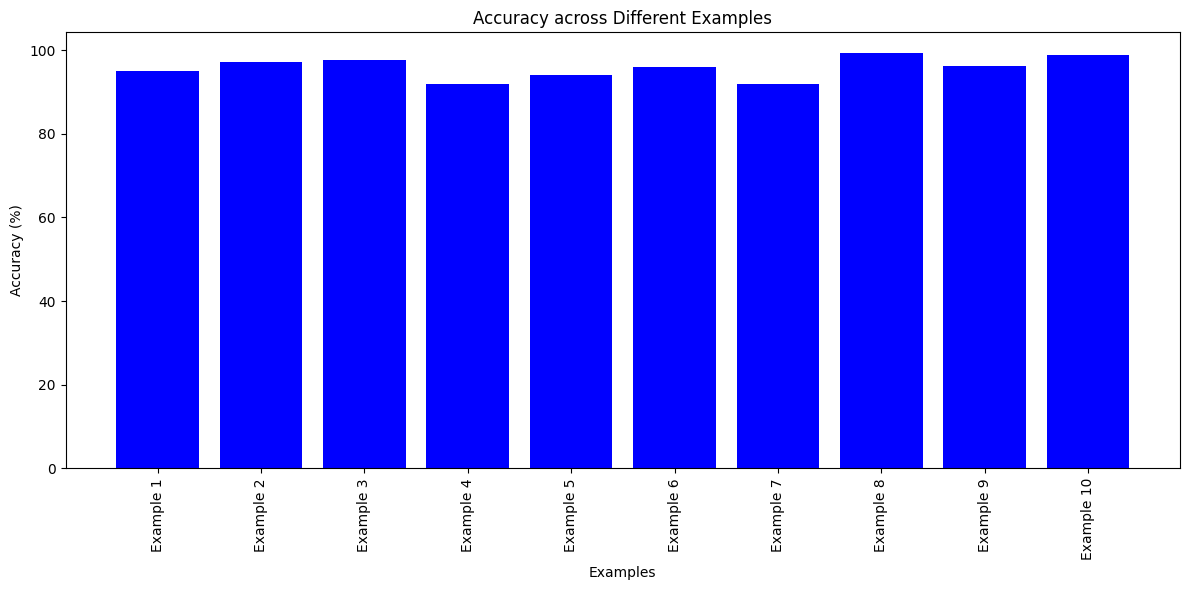

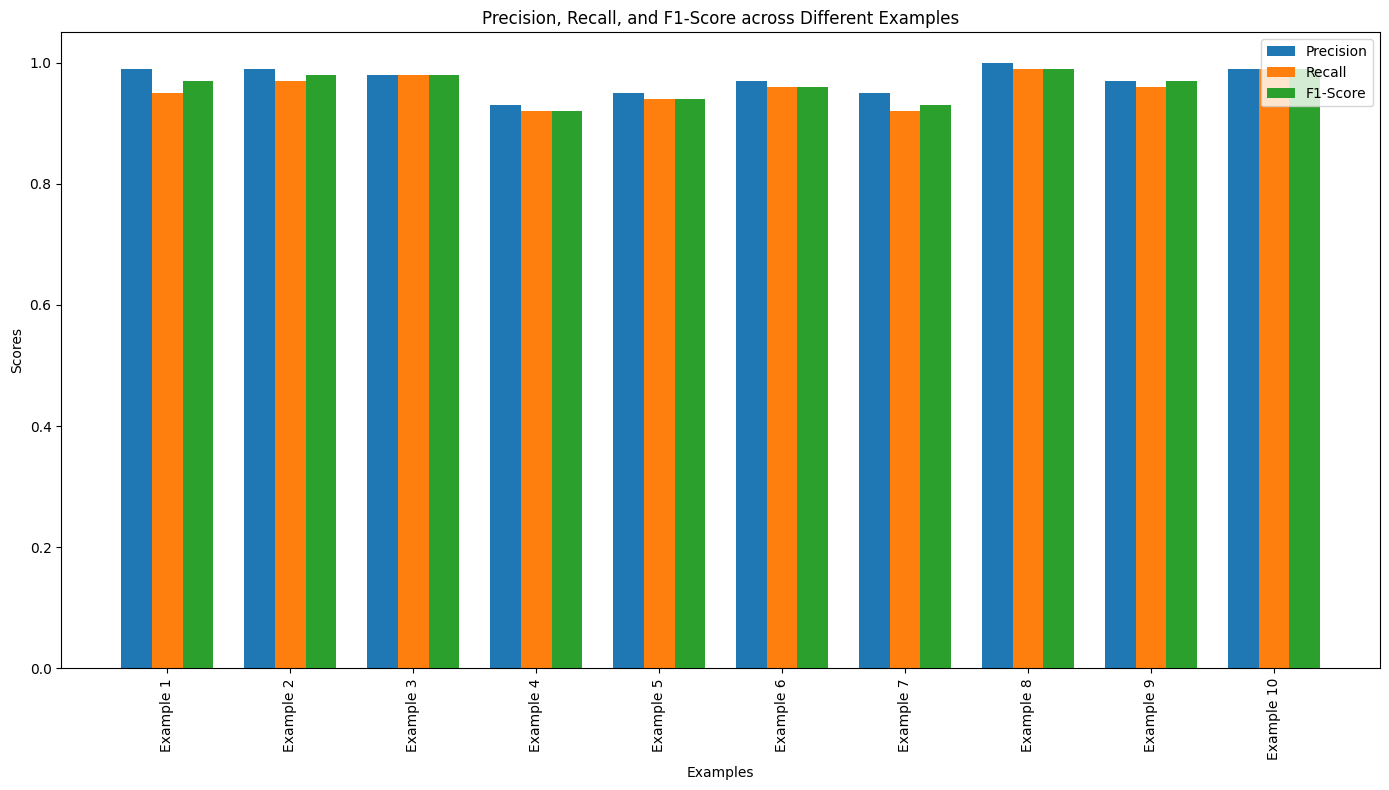

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example metrics data
examples = ['Example 1', 'Example 2', 'Example 3', 'Example 4', 'Example 5',
            'Example 6', 'Example 7', 'Example 8', 'Example 9', 'Example 10']
accuracy = [94.91, 97.16, 97.71, 91.88, 94.10, 96.06, 91.96, 99.29, 96.15, 98.78]
precision = [0.99, 0.99, 0.98, 0.93, 0.95, 0.97, 0.95, 1.00, 0.97, 0.99]
recall = [0.95, 0.97, 0.98, 0.92, 0.94, 0.96, 0.92, 0.99, 0.96, 0.99]
f1_score = [0.97, 0.98, 0.98, 0.92, 0.94, 0.96, 0.93, 0.99, 0.97, 0.99]

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.bar(examples, accuracy, color='blue')
plt.xlabel('Examples')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy across Different Examples')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot Precision, Recall, and F1-Score
x = np.arange(len(examples))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

ax.set_xlabel('Examples')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score across Different Examples')
ax.set_xticks(x)
ax.set_xticklabels(examples, rotation=90)
ax.legend()

fig.tight_layout()
plt.show()




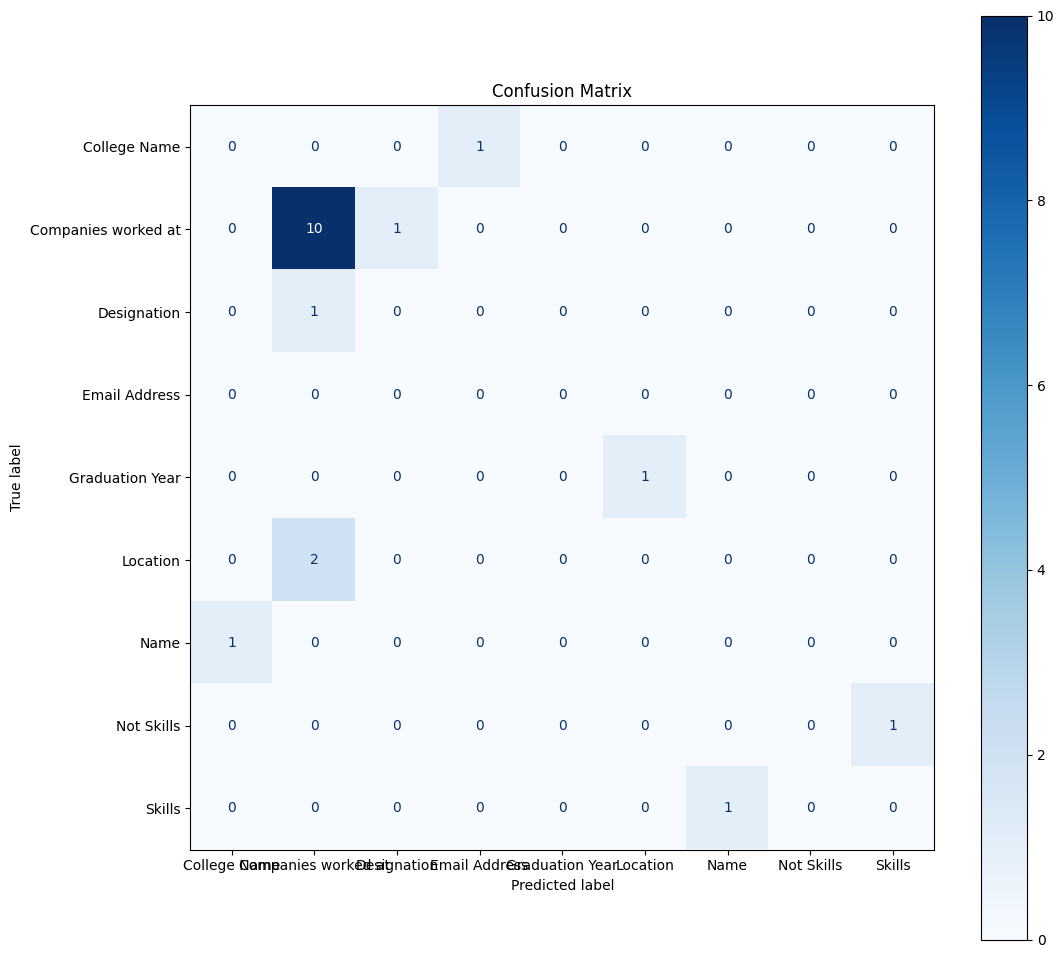

In [ ]:
# Example Confusion Matrix Data
# Replace y_true and y_pred with your actual data
y_true = ['Skills', 'Graduation Year', 'College Name', 'Companies worked at', 'Companies worked at',
          'Companies worked at', 'Companies worked at', 'Companies worked at', 'Companies worked at',
          'Companies worked at', 'Companies worked at', 'Companies worked at', 'Companies worked at',
          'Designation', 'Companies worked at', 'Location', 'Location', 'Name', 'Not Skills']
y_pred = ['Name', 'Location', 'Email Address', 'Designation', 'Companies worked at', 'Companies worked at',
          'Companies worked at', 'Companies worked at', 'Companies worked at', 'Companies worked at',
          'Companies worked at', 'Companies worked at', 'Companies worked at', 'Companies worked at',
          'Companies worked at', 'Companies worked at', 'Companies worked at', 'College Name', 'Skills']

labels = np.unique(y_true + y_pred)
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

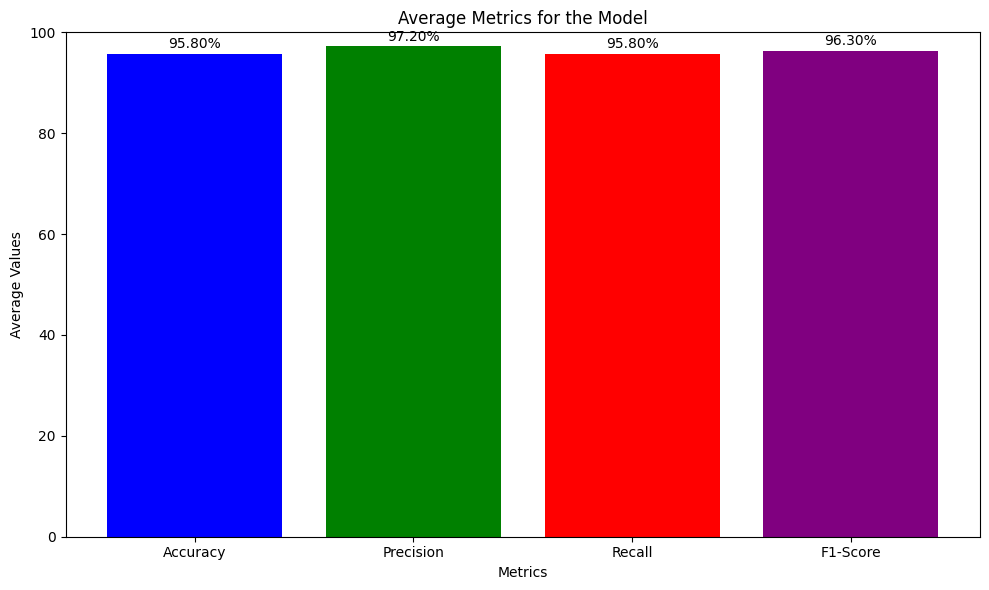

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example metrics data
examples = ['Example 1', 'Example 2', 'Example 3', 'Example 4', 'Example 5',
            'Example 6', 'Example 7', 'Example 8', 'Example 9', 'Example 10']
accuracy = [94.91, 97.16, 97.71, 91.88, 94.10, 96.06, 91.96, 99.29, 96.15, 98.78]
precision = [0.99, 0.99, 0.98, 0.93, 0.95, 0.97, 0.95, 1.00, 0.97, 0.99]
recall = [0.95, 0.97, 0.98, 0.92, 0.94, 0.96, 0.92, 0.99, 0.96, 0.99]
f1_score = [0.97, 0.98, 0.98, 0.92, 0.94, 0.96, 0.93, 0.99, 0.97, 0.99]

# Calculate the averages
average_accuracy = np.mean(accuracy)
average_precision = np.mean(precision) * 100
average_recall = np.mean(recall) * 100
average_f1_score = np.mean(f1_score) * 100

# Plot the averages
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
averages = [average_accuracy, average_precision, average_recall, average_f1_score]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, averages, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Metrics')
plt.ylabel('Average Values')
plt.title('Average Metrics for the Model')
plt.ylim(0, 100)  # Setting the y-axis limit to include values between 0 and 100

# Add percentage labels on top of the bars
for bar, avg in zip(bars, averages):
    yval = bar.get_height()
    offset = 0.5  # Slight offset for accuracy
    plt.text(bar.get_x() + bar.get_width()/2, yval + offset, f'{avg:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


# **40 dataset testing**

# **induvidual evaluation for every example**

In [ ]:
import spacy
from spacy.training import Example
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import json

# Load the spaCy model (ensure you have the model installed, e.g., en_core_web_sm)
nlp = spacy.load("/content/drive/MyDrive/Colab Notebooks/NTT Recog")

# Convert Dataturks to spaCy format function
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    training_data = []
    with open(dataturks_JSON_FilePath, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        for line_number, line in enumerate(lines, 1):
            line = line.strip()
            if not line:  # Skip empty lines
                continue
            try:
                data = json.loads(line)
                text = data['content']
                entities = []
                for annotation in data['annotation']:
                    point = annotation['points'][0]
                    labels = annotation['label']
                    for label in labels:
                        entities.append((int(point['start']), int(point['end']), label))
                training_data.append((text, {'entities': entities}))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line {line_number}: {e}")
                continue
    return training_data

# Debugging predictions function (now summarized)
def debug_predictions_summary(y_true, y_pred):
    print(classification_report(y_true, y_pred, zero_division=0))

# Load and preprocess the test data
examples = convert_dataturks_to_spacy("/content/drive/MyDrive/Colab Notebooks/EntityFrame/testdatanew2.json")

# Print some examples to verify data conversion
print("Converted examples:")
for ex in examples[:2]:  # print first 2 examples for verification
    print(ex)

tp = 0
tr = 0
tf = 0
ta = 0
c = 0
d = {}

for text, annot in examples:
    doc_to_test = nlp(text)

    # Create dictionaries to hold the true and predicted labels
    y_true = []
    y_pred = []
    tokens = [token.text for token in doc_to_test]

    # Extract true and predicted labels
    true_entities = annot['entities']
    pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc_to_test.ents]

    for token in doc_to_test:
        true_label = "Not Label"
        for start, end, label in true_entities:
            if token.idx >= start and token.idx + len(token) <= end:
                true_label = label
                break
        y_true.append(true_label)

        pred_label = "Not Label"
        for start, end, label in pred_entities:
            if token.idx >= start and token.idx + len(token) <= end:
                pred_label = label
                break
        y_pred.append(pred_label)

    # Print true and predicted labels for verification
    print("\nText:", text)
    print("Tokens:", tokens)
    print("True Labels:", y_true)
    print("Predicted Labels:", y_pred)

    # Calculate metrics
    p, r, f, s = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    a = accuracy_score(y_true, y_pred)
    if c in d:
        d[c]['precision'] += p
        d[c]['recall'] += r
        d[c]['f-score'] += f
        d[c]['accuracy'] += a
        d[c]['count'] += 1
    else:
        d[c] = {'precision': p, 'recall': r, 'f-score': f, 'accuracy': a, 'count': 1}

    c += 1

# Calculate average metrics
for i in d:
    print("\nFor Example "+str(i+1)+"\n")
    print("Accuracy : "+str((d[i]['accuracy']/d[i]['count'])*100)+"%")
    print("Precision : "+str(d[i]['precision']/d[i]['count']))
    print("Recall : "+str(d[i]['recall']/d[i]['count']))
    print("F-score : "+str(d[i]['f-score']/d[i]['count']))

    # Summarized debugging output
    debug_predictions_summary(y_true, y_pred)


Streaming output truncated to the last 5000 lines.
• Developed the ANS Management console using Grails and Groovy.
• Worked effectively in the development of 6 modules using Grails and Groovy.

Tools/Environments: Java, Servlets, Jsps, Grails and Groovy, Manual Testing using Soap UI, Jmeter,
Performance testing.

Software Test Analyst

Infosys Limited -  Chennai, Tamil Nadu -

January 2009 to October 2010

Project: PoPs (Purchase order processing System) facilitates the function of buying materials /
components / products / raw materials at economical cost in a timely manner. This will have
broad functionalities of request handling, obtaining quotations including comparison, placing
purchase orders and follow-up of purchase orders for timely deliveries, supplier information,
vendor wise supply analysis, and purchase payments. This covers all type of Enquiry, Quotations,
Comparisons, and Approval of Purchase order. Sending PO to Supplier, maintaining Bills.
Responsibilities:
• Understan

# **common 40 dataset testing**

In [ ]:

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import json
import spacy

# Load the spaCy model (ensure you have the model installed, e.g., en_core_web_sm)
nlp = spacy.load("/content/drive/MyDrive/Colab Notebooks/NTT Recog")

# Convert Dataturks to spaCy format function
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    training_data = []
    with open(dataturks_JSON_FilePath, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        for line_number, line in enumerate(lines, 1):
            line = line.strip()
            if not line:  # Skip empty lines
                continue
            try:
                data = json.loads(line)
                text = data['content']
                entities = []
                for annotation in data['annotation']:
                    point = annotation['points'][0]
                    labels = annotation['label']
                    for label in labels:
                        entities.append((int(point['start']), int(point['end']), label))
                training_data.append((text, {'entities': entities}))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line {line_number}: {e}")
                continue
    return training_data

# Load and preprocess the test data
examples = convert_dataturks_to_spacy("/content/drive/MyDrive/Colab Notebooks/EntityFrame/testdatanew2.json")

all_y_true = []
all_y_pred = []

for text, annot in examples:
    doc_to_test = nlp(text)

    # Create dictionaries to hold the true and predicted labels
    y_true = []
    y_pred = []

    # Extract true and predicted labels
    true_entities = annot['entities']
    pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc_to_test.ents]

    for token in doc_to_test:
        true_label = "Not Label"
        for start, end, label in true_entities:
            if token.idx >= start and token.idx + len(token) <= end:
                true_label = label
                break
        y_true.append(true_label)

        pred_label = "Not Label"
        for start, end, label in pred_entities:
            if token.idx >= start and token.idx + len(token) <= end:
                pred_label = label
                break
        y_pred.append(pred_label)

    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)

# Calculate overall metrics
accuracy = accuracy_score(all_y_true, all_y_pred)
precision, recall, f_score, _ = precision_recall_fscore_support(all_y_true, all_y_pred, average='weighted', zero_division=0)

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F-score: {f_score:.4f}")




Model Evaluation Metrics:
Accuracy: 95.26%
Precision: 0.9515
Recall: 0.9526
F-score: 0.9514


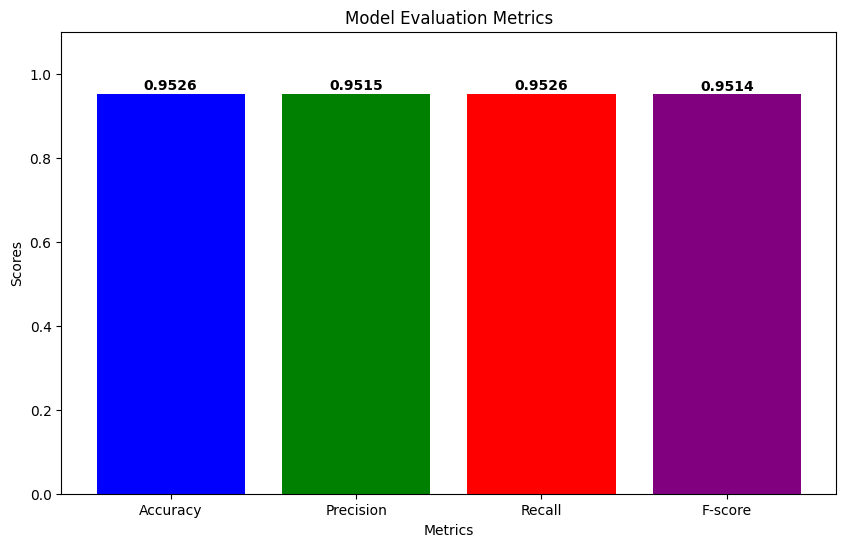

In [ ]:
# Visualize the results
import matplotlib.pyplot as plt
metrics = ['Accuracy', 'Precision', 'Recall', 'F-score']
values = [accuracy, precision, recall, f_score]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1.1)  # Adjust the y-axis to show the full range from 0 to 1.1
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.4f}", ha='center', fontweight='bold', color='black')
plt.show()

# **testing for 50 data**

In [ ]:
import spacy
from spacy.training import Example
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import json

# Load the spaCy model (ensure you have the model installed, e.g., en_core_web_sm)
nlp = spacy.load("/content/drive/MyDrive/Colab Notebooks/NTT Recog")

# Convert Dataturks to spaCy format function
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    training_data = []
    with open(dataturks_JSON_FilePath, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        for line_number, line in enumerate(lines, 1):
            line = line.strip()
            if not line:  # Skip empty lines
                continue
            try:
                data = json.loads(line)
                text = data['content']
                entities = []
                for annotation in data['annotation']:
                    point = annotation['points'][0]
                    labels = annotation['label']
                    for label in labels:
                        entities.append((int(point['start']), int(point['end']), label))
                training_data.append((text, {'entities': entities}))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line {line_number}: {e}")
                continue
    return training_data

# Debugging predictions function (now summarized)
def debug_predictions_summary(y_true, y_pred):
    print(classification_report(y_true, y_pred, zero_division=0))

# Load and preprocess the test data
examples = convert_dataturks_to_spacy("/content/drive/MyDrive/Colab Notebooks/EntityFrame/testdatanew3.json")

# Print some examples to verify data conversion
print("Converted examples:")
for ex in examples[:2]:  # print first 2 examples for verification
    print(ex)

tp = 0
tr = 0
tf = 0
ta = 0
c = 0
d = {}

for text, annot in examples:
    doc_to_test = nlp(text)

    # Create dictionaries to hold the true and predicted labels
    y_true = []
    y_pred = []
    tokens = [token.text for token in doc_to_test]

    # Extract true and predicted labels
    true_entities = annot['entities']
    pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc_to_test.ents]

    for token in doc_to_test:
        true_label = "Not Label"
        for start, end, label in true_entities:
            if token.idx >= start and token.idx + len(token) <= end:
                true_label = label
                break
        y_true.append(true_label)

        pred_label = "Not Label"
        for start, end, label in pred_entities:
            if token.idx >= start and token.idx + len(token) <= end:
                pred_label = label
                break
        y_pred.append(pred_label)

    # Print true and predicted labels for verification
    print("\nText:", text)
    print("Tokens:", tokens)
    print("True Labels:", y_true)
    print("Predicted Labels:", y_pred)

    # Calculate metrics
    p, r, f, s = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    a = accuracy_score(y_true, y_pred)
    if c in d:
        d[c]['precision'] += p
        d[c]['recall'] += r
        d[c]['f-score'] += f
        d[c]['accuracy'] += a
        d[c]['count'] += 1
    else:
        d[c] = {'precision': p, 'recall': r, 'f-score': f, 'accuracy': a, 'count': 1}

    c += 1

# Calculate average metrics
for i in d:
    print("\nFor Example "+str(i+1)+"\n")
    print("Accuracy : "+str((d[i]['accuracy']/d[i]['count'])*100)+"%")
    print("Precision : "+str(d[i]['precision']/d[i]['count']))
    print("Recall : "+str(d[i]['recall']/d[i]['count']))
    print("F-score : "+str(d[i]['f-score']/d[i]['count']))

    # Summarized debugging output
    debug_predictions_summary(y_true, y_pred)


Streaming output truncated to the last 5000 lines.
• Web API enhancements.



EDUCATION

Saurashtra University -  Morbi, Gujarat

2007

SKILLS

problem solving (Less than 1 year), project lifecycle (Less than 1 year), project manager (Less
than 1 year), technical assistance. (Less than 1 year)

ADDITIONAL INFORMATION

Professional Skills
• Excellent analytical, problem solving, communication, knowledge transfer and interpersonal
skills with ability to interact with individuals at all the levels
• Quick learner and maintains cordial relationship with project manager and team members and
good performer both in team and independent job environments
• Positive attitude towards superiors & peers
• Supervised junior developers throughout project lifecycle and provided technical assistance.
Tokens: ['Michael', 'Johnson', '\n', 'BI', '/', 'Big', 'Data/', 'Azure', '\n\n', 'Chicago', ',', 'Illinois', '-', 'Email', 'me', 'on', 'Indeed', ':', 'indeed.com/r/Michael-Johnson/9876543abcdef', '\n\n', '

In [ ]:

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import json
import spacy

# Load the spaCy model (ensure you have the model installed, e.g., en_core_web_sm)
nlp = spacy.load("/content/drive/MyDrive/Colab Notebooks/NTT Recog")

# Convert Dataturks to spaCy format function
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    training_data = []
    with open(dataturks_JSON_FilePath, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        for line_number, line in enumerate(lines, 1):
            line = line.strip()
            if not line:  # Skip empty lines
                continue
            try:
                data = json.loads(line)
                text = data['content']
                entities = []
                for annotation in data['annotation']:
                    point = annotation['points'][0]
                    labels = annotation['label']
                    for label in labels:
                        entities.append((int(point['start']), int(point['end']), label))
                training_data.append((text, {'entities': entities}))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line {line_number}: {e}")
                continue
    return training_data

# Load and preprocess the test data
examples = convert_dataturks_to_spacy("/content/drive/MyDrive/Colab Notebooks/EntityFrame/testdatanew3.json")

all_y_true = []
all_y_pred = []

for text, annot in examples:
    doc_to_test = nlp(text)

    # Create dictionaries to hold the true and predicted labels
    y_true = []
    y_pred = []

    # Extract true and predicted labels
    true_entities = annot['entities']
    pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc_to_test.ents]

    for token in doc_to_test:
        true_label = "Not Label"
        for start, end, label in true_entities:
            if token.idx >= start and token.idx + len(token) <= end:
                true_label = label
                break
        y_true.append(true_label)

        pred_label = "Not Label"
        for start, end, label in pred_entities:
            if token.idx >= start and token.idx + len(token) <= end:
                pred_label = label
                break
        y_pred.append(pred_label)

    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)

# Calculate overall metrics
accuracy = accuracy_score(all_y_true, all_y_pred)
precision, recall, f_score, _ = precision_recall_fscore_support(all_y_true, all_y_pred, average='weighted', zero_division=0)

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F-score: {f_score:.4f}")




Model Evaluation Metrics:
Accuracy: 94.91%
Precision: 0.9458
Recall: 0.9491
F-score: 0.9468


**45
Model Evaluation Metrics:
Accuracy: 95.04%
Precision: 0.9483
Recall: 0.9504
F-score: 0.9488
after 50
Model Evaluation Metrics:
Accuracy: 94.91%
Precision: 0.9458
Recall: 0.9491
F-score: 0.9468 **

**more than 50**

In [ ]:
import spacy
from spacy.training import Example
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import json

# Load the spaCy model (ensure you have the model installed, e.g., en_core_web_sm)
nlp = spacy.load("/content/drive/MyDrive/Colab Notebooks/NTT Recog")

# Convert Dataturks to spaCy format function
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    training_data = []
    with open(dataturks_JSON_FilePath, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        for line_number, line in enumerate(lines, 1):
            line = line.strip()
            if not line:  # Skip empty lines
                continue
            try:
                data = json.loads(line)
                text = data['content']
                entities = []
                for annotation in data['annotation']:
                    point = annotation['points'][0]
                    labels = annotation['label']
                    for label in labels:
                        entities.append((int(point['start']), int(point['end']), label))
                training_data.append((text, {'entities': entities}))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line {line_number}: {e}")
                continue
    return training_data

# Debugging predictions function (now summarized)
def debug_predictions_summary(y_true, y_pred):
    print(classification_report(y_true, y_pred, zero_division=0))

# Load and preprocess the test data
examples = convert_dataturks_to_spacy("/content/drive/MyDrive/Colab Notebooks/EntityFrame/testdatanew4.json")

# Print some examples to verify data conversion
print("Converted examples:")
for ex in examples[:2]:  # print first 2 examples for verification
    print(ex)

tp = 0
tr = 0
tf = 0
ta = 0
c = 0
d = {}

for text, annot in examples:
    doc_to_test = nlp(text)

    # Create dictionaries to hold the true and predicted labels
    y_true = []
    y_pred = []
    tokens = [token.text for token in doc_to_test]

    # Extract true and predicted labels
    true_entities = annot['entities']
    pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc_to_test.ents]

    for token in doc_to_test:
        true_label = "Not Label"
        for start, end, label in true_entities:
            if token.idx >= start and token.idx + len(token) <= end:
                true_label = label
                break
        y_true.append(true_label)

        pred_label = "Not Label"
        for start, end, label in pred_entities:
            if token.idx >= start and token.idx + len(token) <= end:
                pred_label = label
                break
        y_pred.append(pred_label)

    # Print true and predicted labels for verification
    #print("\nText:", text)
    #print("Tokens:", tokens)
    #print("True Labels:", y_true)
    #print("Predicted Labels:", y_pred)

    # Calculate metrics
    p, r, f, s = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    a = accuracy_score(y_true, y_pred)
    if c in d:
        d[c]['precision'] += p
        d[c]['recall'] += r
        d[c]['f-score'] += f
        d[c]['accuracy'] += a
        d[c]['count'] += 1
    else:
        d[c] = {'precision': p, 'recall': r, 'f-score': f, 'accuracy': a, 'count': 1}

    c += 1

# Calculate average metrics
for i in d:
    print("\nFor Example "+str(i+1)+"\n")
    print("Accuracy : "+str((d[i]['accuracy']/d[i]['count'])*100)+"%")
    print("Precision : "+str(d[i]['precision']/d[i]['count']))
    print("Recall : "+str(d[i]['recall']/d[i]['count']))
    print("F-score : "+str(d[i]['f-score']/d[i]['count']))

    # Summarized debugging output
    debug_predictions_summary(y_true, y_pred)


Error decoding JSON on line 32: Expecting value: line 1 column 1 (char 0)
Error decoding JSON on line 38: Expecting value: line 1 column 1 (char 0)
Error decoding JSON on line 41: Expecting value: line 1 column 1 (char 0)
Converted examples:
("Akhil Yadav Polemaina\nHyderabad, Telangana - Email me on Indeed: indeed.com/r/Akhil-Yadav-Polemaina/\nf6931801c51c63b1\n\n● Senior System Engineer at Infosys with 3.2 years of experience in software development and\nMaintenance.\n● Maintained data processing using mainframe technology for multiple front end applications of\nWalmart Retail Link platform and ensured on-time deliverables.\n● Worked on automating the uses cases to reduce manual effort in solving repeating incidents\nusing Service Now orchestration.\n● Possess good analytical, logical ability and systematic approach to problem analysis, strong\ndebugging and troubleshooting skills.\n● Good exposure to Retail domain.\n\nWilling to relocate to: hyderbad, Telangana\n\nWORK EXPERIENCE\n\

In [ ]:

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import json
import spacy

# Load the spaCy model (ensure you have the model installed, e.g., en_core_web_sm)
nlp = spacy.load("/content/drive/MyDrive/Colab Notebooks/NTT Recog")

# Convert Dataturks to spaCy format function
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    training_data = []
    with open(dataturks_JSON_FilePath, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        for line_number, line in enumerate(lines, 1):
            line = line.strip()
            if not line:  # Skip empty lines
                continue
            try:
                data = json.loads(line)
                text = data['content']
                entities = []
                for annotation in data['annotation']:
                    point = annotation['points'][0]
                    labels = annotation['label']
                    for label in labels:
                        entities.append((int(point['start']), int(point['end']), label))
                training_data.append((text, {'entities': entities}))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line {line_number}: {e}")
                continue
    return training_data

# Load and preprocess the test data
examples = convert_dataturks_to_spacy("/content/drive/MyDrive/Colab Notebooks/EntityFrame/testdatanew4.json")

all_y_true = []
all_y_pred = []

for text, annot in examples:
    doc_to_test = nlp(text)

    # Create dictionaries to hold the true and predicted labels
    y_true = []
    y_pred = []

    # Extract true and predicted labels
    true_entities = annot['entities']
    pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc_to_test.ents]

    for token in doc_to_test:
        true_label = "Not Label"
        for start, end, label in true_entities:
            if token.idx >= start and token.idx + len(token) <= end:
                true_label = label
                break
        y_true.append(true_label)

        pred_label = "Not Label"
        for start, end, label in pred_entities:
            if token.idx >= start and token.idx + len(token) <= end:
                pred_label = label
                break
        y_pred.append(pred_label)

    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)

# Calculate overall metrics
accuracy = accuracy_score(all_y_true, all_y_pred)
precision, recall, f_score, _ = precision_recall_fscore_support(all_y_true, all_y_pred, average='weighted', zero_division=0)

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F-score: {f_score:.4f}")




Error decoding JSON on line 32: Expecting value: line 1 column 1 (char 0)
Error decoding JSON on line 38: Expecting value: line 1 column 1 (char 0)
Error decoding JSON on line 41: Expecting value: line 1 column 1 (char 0)
Error decoding JSON on line 42: Expecting value: line 1 column 1 (char 0)
Model Evaluation Metrics:
Accuracy: 95.05%
Precision: 0.9462
Recall: 0.9505
F-score: 0.9478


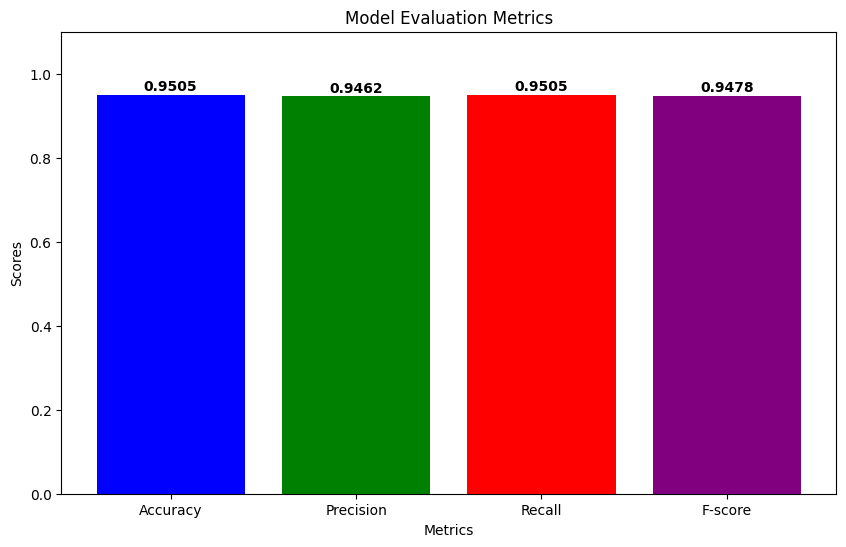

In [ ]:
# Visualize the results
import matplotlib.pyplot as plt
metrics = ['Accuracy', 'Precision', 'Recall', 'F-score']
values = [accuracy, precision, recall, f_score]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1.1)  # Adjust the y-axis to show the full range from 0 to 1.1
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.4f}", ha='center', fontweight='bold', color='black')
plt.show()